# **BERT-based film recomend system**
The film recommend system uses [`MovieLens1M`](https://grouplens.org/datasets/movielens/) as dataset.



## **0. upload package**

In [ ]:
! pip3 install sentence_transformers

In [1]:
import os
import pickle
import re
import time
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import summary_ops_v2

from sentence_transformers import SentenceTransformer, models

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Data Preparing**

### 1.1 dataset

This project uses the MovieLens 1M dataset, which contains 1 million ratings from 6,000 users on approximately 4,000 movies.

The dataset is divided into three files:

users.dat – user information

movies.dat – movie information

ratings.dat – user ratings for movies

In [6]:
%cd '/content/drive/MyDrive/Colab Notebooks/project/MovieLens/'

/content/drive/MyDrive/Colab Notebooks/project/MovieLens


#### 1.1.1 User data
It contains the following fields: UserID, Gender, Age, Occupation ID, and Zip-code.

The format of the data is:

UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



In [7]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


It can be seen that UserID, Gender, Age, and Occupation are categorical features, while the Zip-code field is not used in our analysis.

#### 1.1.2 Film data
Each entry contains fields such as MovieID, Title, and Genres.

The format of the data is:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [8]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python', encoding='latin-1')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


MovieID is a categorical feature, Title is a text field, and Genres is also a categorical feature.

#### 1.1.3 Rating data
It contains fields such as UserID, MovieID, Rating, and Timestamp.

The data format is:

UserID::MovieID::Rating::Timestamp.

- UserIDs range between 1 and 6040
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [9]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


The Rating field is the target we aim to learn, while the Timestamp field will not be used.

### 1.2 Data Preprocessing

- UserID、Occupation and MovieID keep the same.
- Gender:convert 'F' and 'M' into 0 and 1.
- Age:convert to 7 integers (0~6)。
- Genres:convert into list using one-hot embedding.
- Title:convert into sentence embeddings using Sentence-BERT.

#### 1.2.1 User dataset

In [10]:
#reading User data
users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users = users.filter(regex='UserID|Gender|Age|JobID')
users_orig = users.values
#convert gender and age
gender_map = {'F':0, 'M':1}
users['Gender'] = users['Gender'].map(gender_map)

age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
users['Age'] = users['Age'].map(age_map)

#### 1.2.2 Movie dataset

In [11]:
# reading Movie data
movies_title = ['MovieID', 'Title', 'Genres']
movies_saved = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python',encoding  = 'latin-1')
movies_orig = movies_saved.values

In [12]:
movies_saved.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movies = movies_saved.copy()

##### 1.2.2.1 Movie dataset Title processing


Extracted release years from movie titles into a separate Year column and cleaned the Title field for better feature representation.

In [14]:
pattern = re.compile(r'^(.*)\((\d{4})\)$')
movies['Year'] = movies['Title'].apply(lambda x: pattern.match(x).group(2) if pattern.match(x) else None)
movies['Title'] = movies['Title'].apply(lambda x: pattern.match(x).group(1).strip() if pattern.match(x) else x)

In [15]:
movies['Year'] = movies['Year'].astype(int)

In [16]:
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [17]:
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length = 16) # embedding model
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension()) # pooling layer
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

title_encoded=model.encode(movies.Title[:]) # Embed the Title

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
title_encoded[0].shape

(768,)

In [19]:
#Use PCA to reduce the embedding of each sentence to 2 dimensions and visualize the effect of Sentence BERT embeddingpca = PCA(n_components=2)
pca = PCA(n_components=2)
pca.fit(title_encoded)
print(pca.explained_variance_ratio_)

[0.11521395 0.05498714]


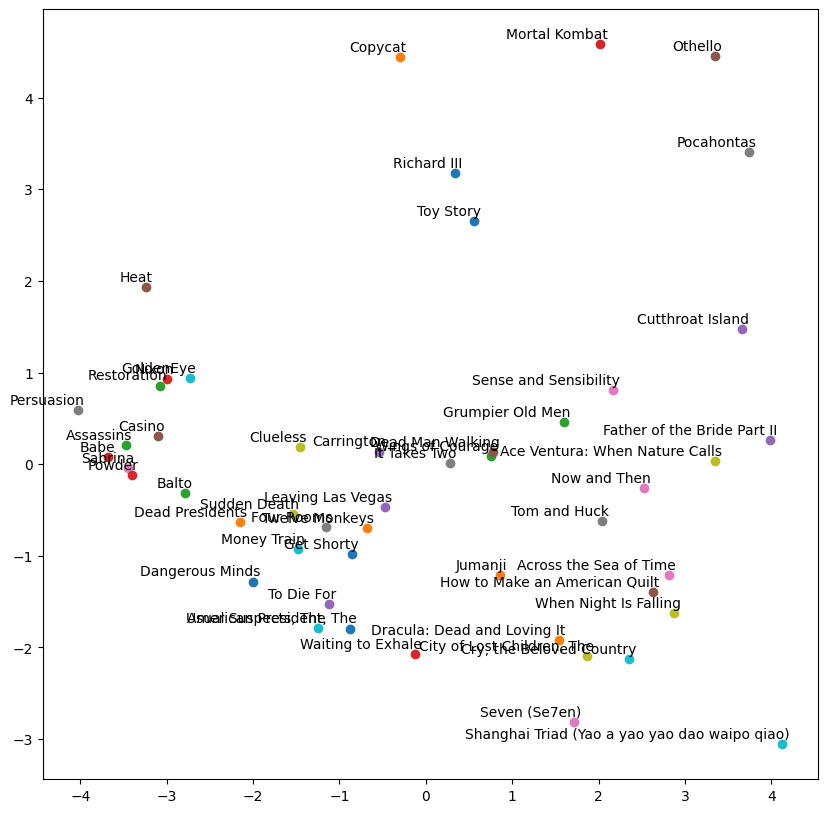

In [20]:
#visualize 50 Title embedding
plot_only = 50
low_dim_embs = pca.fit_transform(title_encoded[:plot_only])
labels = [movies.Title[i] for i in range(plot_only)]

plt.figure(figsize=(10, 10))
for i, label in enumerate(labels):
  x, y = low_dim_embs[i, :]
  plt.scatter(x, y)
  plt.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')

##### 1.2.2.2 Other column in Movie dataset

In [21]:
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [22]:
#movies = movies_saved.copy()

In [23]:
#one-hot on film genres
movies.Genres=movies.Genres.apply(lambda x: x.split('|'))
genres=[
    'Action',
    'Adventure',
    'Animation',
    "Children's",
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
    'Western'
    ]



In [24]:
for i in genres:
  movies[i] = movies.Genres.apply(lambda x: i in x).astype(int)

classes = movies.iloc[:,4:].values
movies['category'] = list(classes)

In [25]:
movies.drop(columns=['Action','Genres','Adventure',
    'Animation',
    "Children's",
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
    'Western'],inplace=True)

In [26]:
movies = movies[['MovieID','Year', 'Title', 'category']]

In [27]:
movies.head()

,MovieID,Year,Title,category
0,1,1995,Toy Story,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1995,Jumanji,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,1995,Grumpier Old Men,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,1995,Waiting to Exhale,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,1995,Father of the Bride Part II,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
#Use embedding to present title
for i in range(len(movies)):
  movies['Title'][i] = title_encoded[i]

流式输出内容被截断，只能显示最后 5000 行内容。
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  movies['Title'][i] = title_encoded[i]
/tmp/ipython-input-28-2290231108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['Title'][i] = title_encoded[i]
/tmp/ipython-input-28-2290231108.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting 

In [29]:
movies.dtypes

,0
MovieID,int64
Year,int64
Title,object
category,object


#### 1.2.3 Dataset Merge

In [30]:
#Read rating dataset
ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings = ratings.filter(regex='UserID|MovieID|ratings')

#Merge
data = pd.merge(pd.merge(ratings, users), movies)

#Split data into feature dataframe and target dataframe
target_fields = ['ratings']
features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]

#convert to numpy list
features = features_pd.values
targets_values = targets_pd.values

In [31]:
features_pd.head()

,UserID,MovieID,Gender,Age,JobID,Year,Title,category
0,1,1193,0,0,10,1975,"[0.33654454, 0.09675352, -0.31076208, -0.13923...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,661,0,0,10,1996,"[-0.2518726, -0.2118336, -0.5492688, 0.0692299...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,1,914,0,0,10,1964,"[0.046552993, 0.16525617, 0.199461, -0.1046696...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
3,1,3408,0,0,10,2000,"[0.27461818, -0.16849202, -0.07137128, -0.2840...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,2355,0,0,10,1998,"[-0.092186615, 0.10288194, -0.05263467, -0.124...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [101]:
features[0][7].shape

(18,)

#### 1.2.4 Data aftering preprocessing

In [32]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [33]:
movies.head()

,MovieID,Year,Title,category
0,1,1995,"[0.13749607, -0.10785808, -0.2520607, -0.13676...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1995,"[-0.09711006, -0.5188881, -0.30558696, -0.2615...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,1995,"[-0.118097164, 0.10498004, 0.086017266, 0.0284...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,1995,"[0.35723495, -0.14458226, 0.15157299, -0.09572...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,1995,"[-0.5462986, -0.35121715, 0.40437844, -0.27419...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [79]:
data.head()

,UserID,MovieID,ratings,Gender,Age,JobID,Year,Title,category
0,1,1193,5,0,0,10,1975,"[0.33654454, 0.09675352, -0.31076208, -0.13923...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,661,3,0,0,10,1996,"[-0.2518726, -0.2118336, -0.5492688, 0.0692299...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,1,914,3,0,0,10,1964,"[0.046552993, 0.16525617, 0.199461, -0.1046696...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
3,1,3408,4,0,0,10,2000,"[0.27461818, -0.16849202, -0.07137128, -0.2840...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,2355,5,0,0,10,1998,"[-0.092186615, 0.10288194, -0.05263467, -0.124...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [63]:
data['category'][0].shape

(18,)

## **2. Model Design**

### 2.1 Predefination

#### 2.1.1 Variable

In [35]:
#emedding dim
embed_dim = 32
#number of user id
uid_max = max(features.take(0,1)) + 1  #6040
#number of genders
gender_max = max(features.take(2,1)) + 1  #2
#number of age range
age_max = max(features.take(3,1)) + 1  #7
#number of jobs
job_max = max(features.take(4,1)) + 1   #21
#number of movie id
movie_id_max = max(features.take(1,1)) + 1  #3952
#number of movie year
movie_year_count = len(np.unique(features[:,4]))  #21
#len of film title embedding
sentences_size = title_count  = 768

#### 2.1.2 Hyperparameters

In [36]:
#Number of Epochs
num_epochs = 10

#Batch Size
batch_size = 256

#dropout
dropout_keep = 0.5

#Learning Rate
learning_rate = 0.0005

#Show stats for every n number of batches
show_every_n_batches = 20

#save path
save_dir = './save'

#### 2.1.3 Placeholder

In [80]:
def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age')
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id')
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories')
    movie_titles = tf.keras.layers.Input(shape=(768,), dtype='float32', name='movie_titles')
    movie_years = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_years')
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, movie_years

### 2.2 Build a neural network

#### 2.2.1 Define the embedding matrix of User ID, age, job

In [81]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 2.2.2 Fully connect the User's embedding matrix to generate User's features


In [82]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    #first fully connected layer
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    #second fully connected layer
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  #(?, 1, 200)

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    # dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(user_combine_layer_flat)
    return user_combine_layer, user_combine_layer_flat

#### 2.2.3 Define the embedding matrix of Movie ID, years, genres, and Title



##### 2.2.3.1 Define the embedding matrix of Movie ID

In [83]:
def get_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    movie_id_embed_layer_flat = tf.keras.layers.Flatten(name="movie_id_embed_layer_flat")(movie_id_embed_layer)

    return movie_id_embed_layer_flat

##### 2.2.3.2 Define the embedding matrix of Movie genres

In [84]:
def get_movie_categories_layers(movie_categories):
  movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories)
  return movie_categories_fc_layer

##### 2.2.3.3 Define the embedding matrix of Movie Title

In [85]:
def get_movie_titles_layers(movie_titles):
  movie_titles_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_titles_fc_layer", activation='relu')(movie_titles)
  return movie_titles_fc_layer

##### 2.2.3.4 Define the embedding matrix of Movie Year

In [86]:
def get_movie_years_layers(movie_years):
  movie_year_embed_layer = tf.keras.layers.Embedding(movie_year_count, embed_dim, input_length=1, name='movie_year_embed_layer')(movie_years)
  movie_year_embed_flat = tf.keras.layers.Flatten(name='movie_year_embed_flat')(movie_year_embed_layer)
  return movie_year_embed_flat

#### 2.2.4 Fully connect the embedding matrix of Movie to generate the features of Movie


In [87]:
def get_movie_feature_layer(movie_id_embed_layer_flat, movie_categories_fc_layer, movie_titles_fc_layer, movie_years_fc_layer):
    #first fully connected layer
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer_flat)

    #second fully connected layer
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, movie_titles_fc_layer, movie_years_fc_layer], 1)
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Flatten(name="movie_combine_layer_flat")(movie_combine_layer)
    # dropout_layer1 = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer1")(movie_combine_layer_flat)
    return movie_combine_layer, movie_combine_layer_flat

#### 2.2.5 构建Tensorflow计算图

In [106]:
MODEL_DIR = "./models"


class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        # input placeholder
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, movie_years = get_inputs()
        # embedding vectors of User
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
        # user characteristics
        user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
        # embedding vectorof the movie ID
        movie_id_embed_layer_flat = get_movie_id_embed_layer(movie_id)
        # embedding vector of movie categories
        movie_categories_fc_layer = get_movie_categories_layers(movie_categories)
        # feature vector of the movie name
        movie_titles_fc_layer = get_movie_titles_layers(movie_titles)
        # feature vector for movie year
        movie_years_fc_layer = get_movie_years_layers(movie_years)
        # movies features
        movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(
            movie_id_embed_layer_flat,
            movie_categories_fc_layer,
            movie_titles_fc_layer,
            movie_years_fc_layer)

        # perform matrix multiplication on user features and movie features to get a predicted rating solution
        inference = tf.keras.layers.Lambda(lambda layer:
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)

        self.model = tf.keras.Model(
            inputs=[uid, movie_id, user_gender, user_age, user_job, movie_years, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        # MSE loss
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanSquaredError()

        if tf.io.gfile.exists(MODEL_DIR):
            print('Removing existing model dir: {}'.format(MODEL_DIR))
            tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        #         self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        #         self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mse(labels, logits)  #

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        #         metrics = 0
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6],
                                 x[7]], training=True)
            loss = self.ComputeLoss(y, logits)
            # loss = self.compute_loss(labels, logits)
            self.ComputeMetrics(y, logits)
            # metrics = self.compute_metrics(labels, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=7, log_freq=50):
        train_X, test_X, train_y, test_y = train_test_split(features, targets_values, test_size=0.2, random_state=0)
        for epoch_i in range(epochs):
            # shuffle the training set
            state = np.random.get_state()
            np.random.shuffle(train_X)

            np.random.set_state(state)
            np.random.shuffle(train_y)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            #             with self.train_summary_writer.as_default():
            if True:
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                #                 avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(7, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(6, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(5, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        #                         summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        #                         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=self.optimizer.iterations)
                        # summary_ops_v2.scalar('mae', avg_mae.result(), step=self.optimizer.iterations)

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mse: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        # print('Step #{}\tLoss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                        #     self.optimizer.iterations.numpy(), loss, (avg_mae.result()), rate))
                        avg_loss.reset_state()
                        self.ComputeMetrics.reset_state()
                        # avg_mae.reset_states()
                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            #             with self.test_summary_writer.as_default():
            self.testing((test_X, test_y), self.optimizer.iterations)
            # self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        #         avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(7, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(6, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(5, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            # save test loss
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            # avg_loss(self.compute_loss(labels, logits))
            # avg_mae(self.compute_metrics(labels, logits))

        print('Model test set loss: {:0.6f} mse: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))
        # print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), avg_mae.result()))
        #         summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        #         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=step_num)
        # summary_ops_v2.scalar('mae', avg_mae.result(), step=step_num)

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        # logits = tf.nn.softmax(predictions)

        return predictions

In [107]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

### 2.3 Train the netural network

In [108]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=7)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie_id (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 uid (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 user_gender (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_age (InputLayer)       [(None, 1)]                  0         []                            
                                                                                           

### 2.4 Visualize the training result

#### 2.4.1 Training Loss

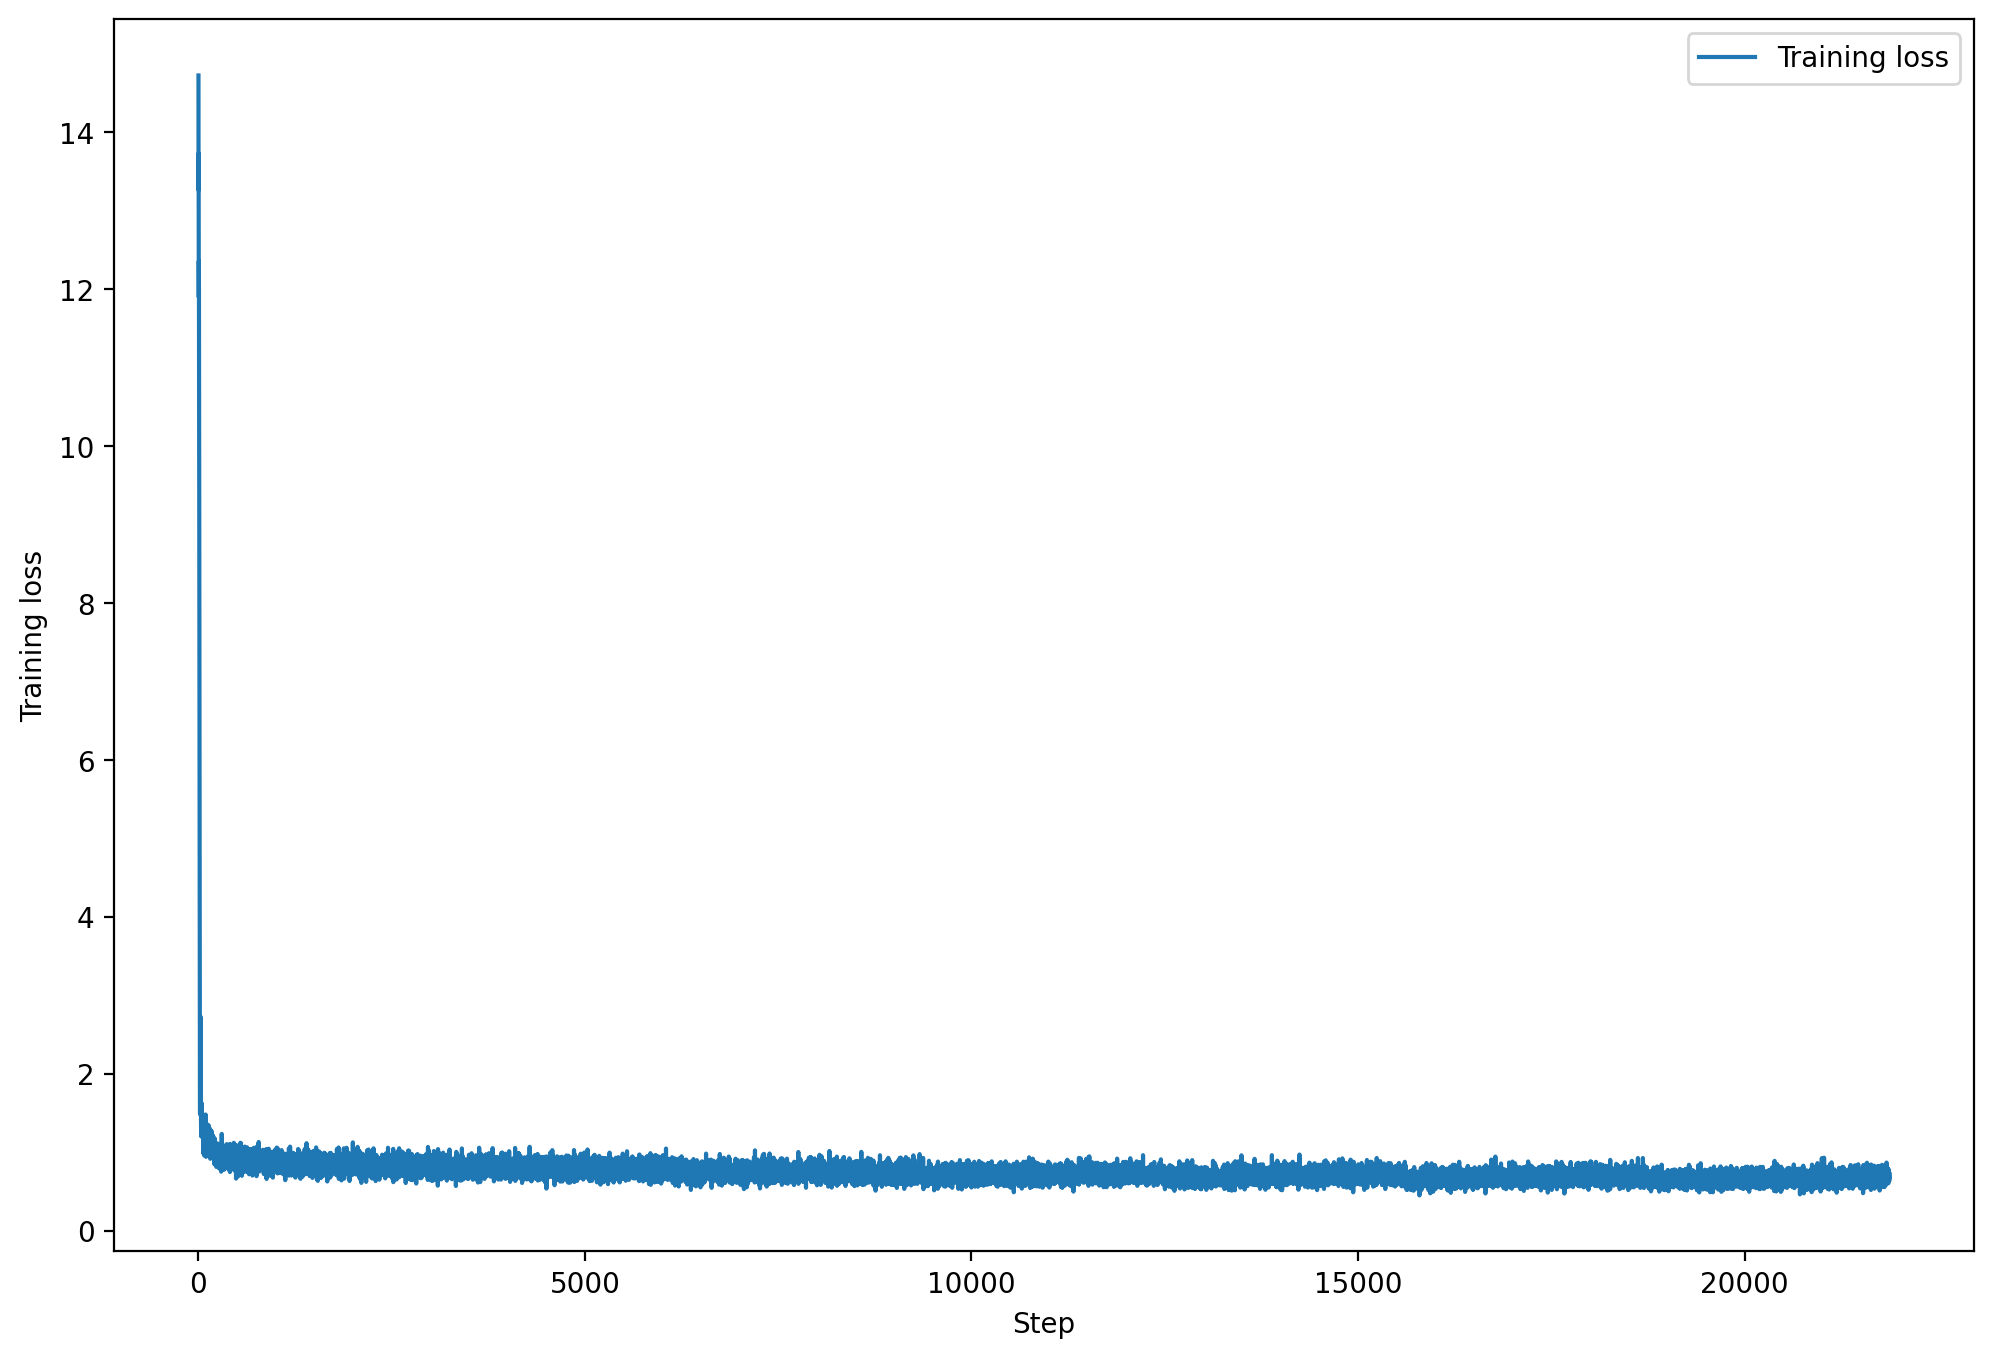

In [109]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(mv_net.losses['train'], label='Training loss')
plt.xlabel('Step')
plt.ylabel('Training loss')
plt.legend()
_ = plt.ylim()

#### 2.4.2 Testing Loss

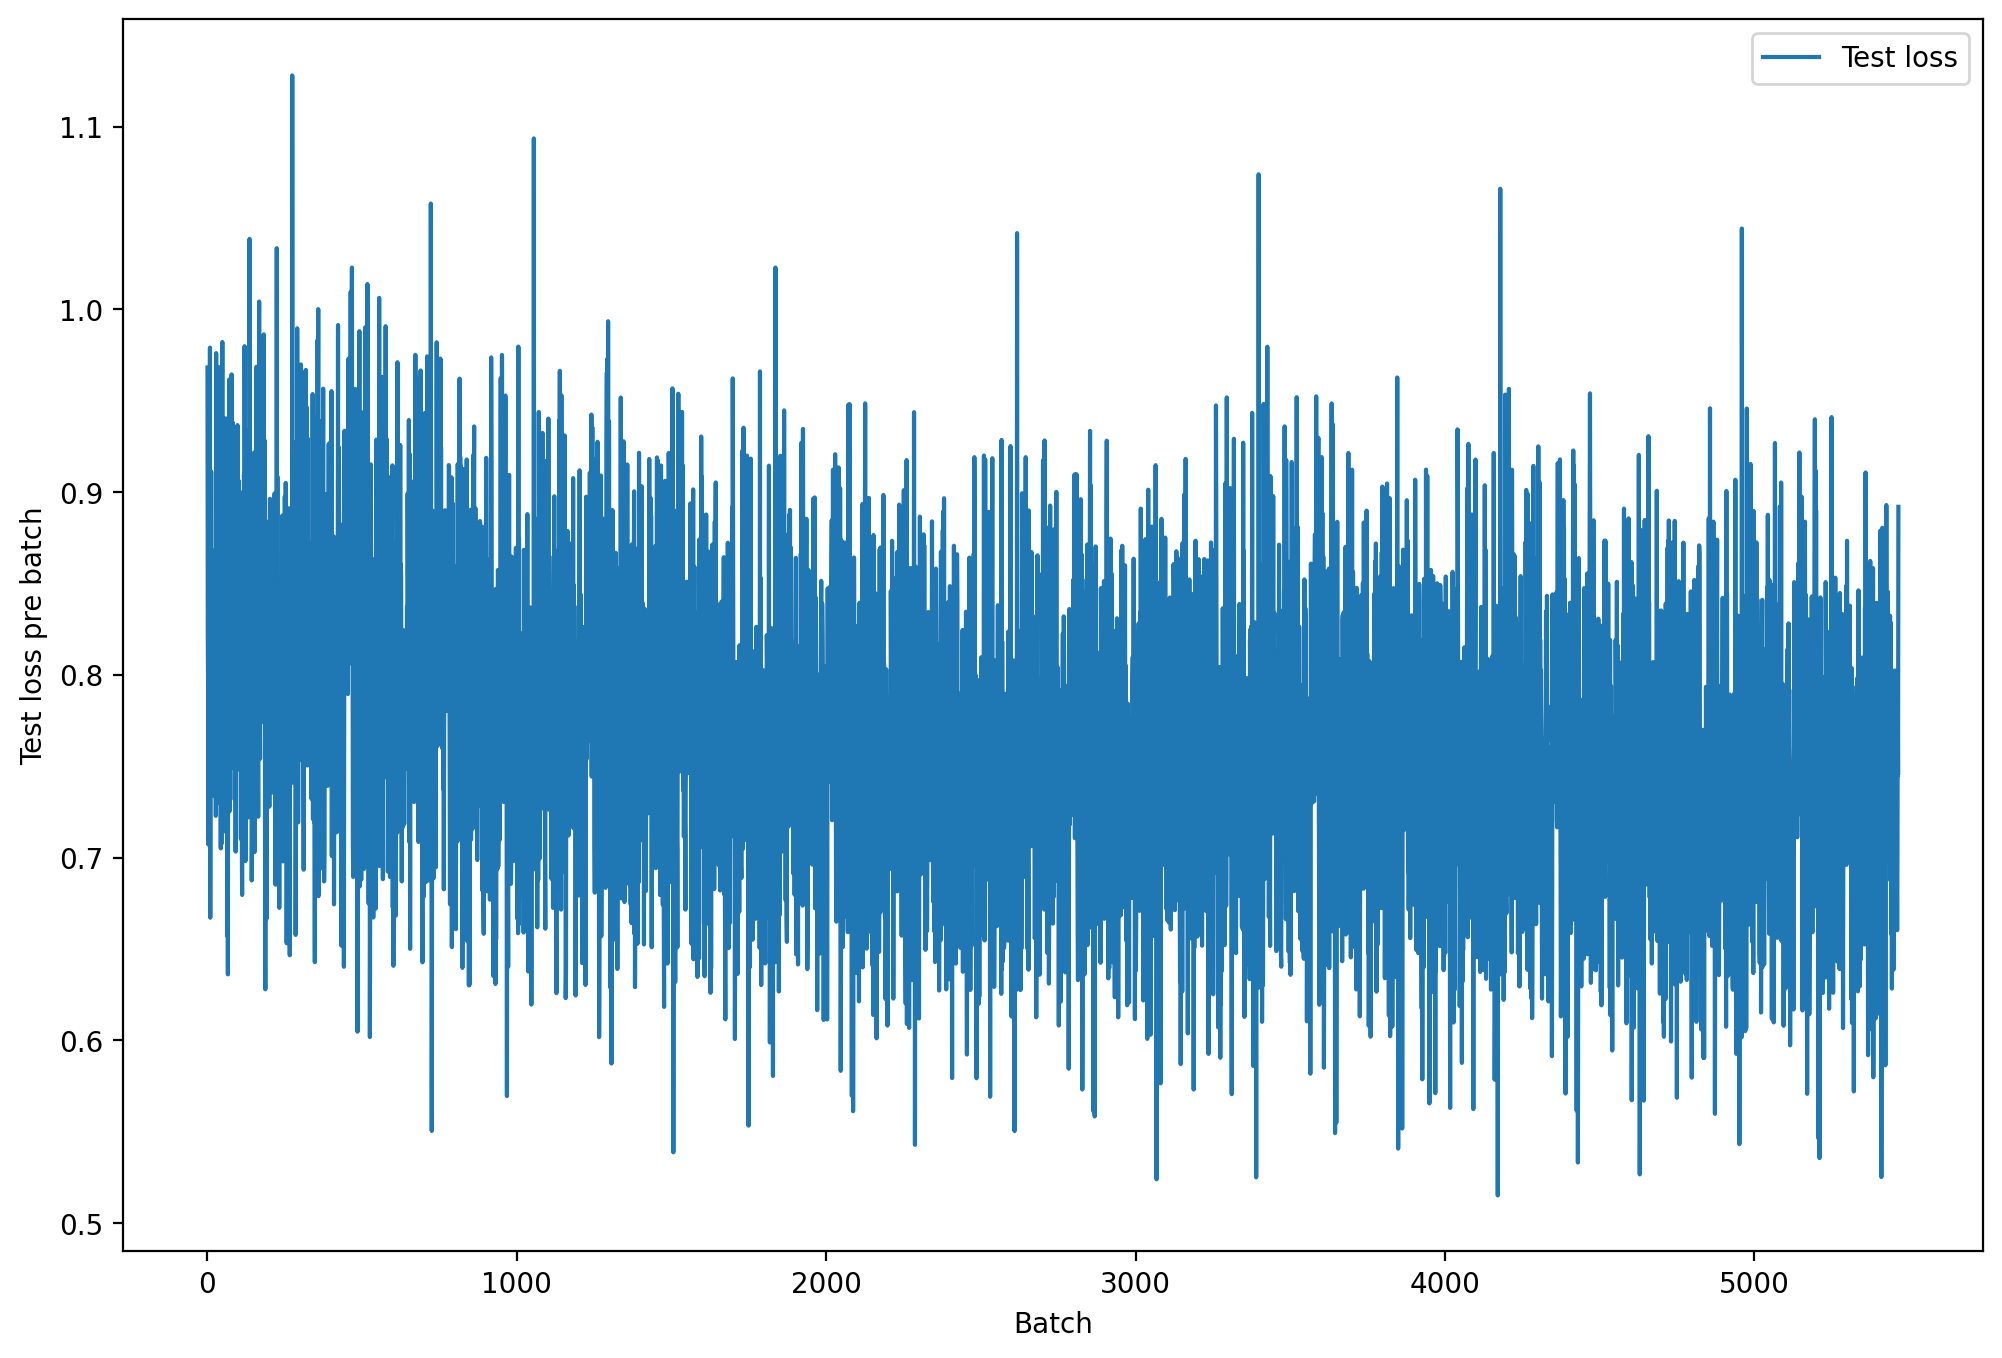

In [110]:
plt.figure(figsize=(12,8))
plt.plot(mv_net.losses['test'], label='Test loss')
plt.xlabel('Batch')
plt.ylabel('Test loss pre batch')
plt.legend()
_ = plt.ylim()

## **3. Using the model for movie recommendations**

### 3.1 Movie feature matrix
Combine the trained movie features into a movie feature matrix and save it locally


In [140]:
for i, inp in enumerate(mv_net.model.input):
    print(f"{i} - {inp.name}")


0 - uid
1 - movie_id
2 - user_gender
3 - user_age
4 - user_job
5 - movie_years
6 - movie_categories
7 - movie_titles


In [141]:
movie_layer_model = keras.models.Model(inputs=[mv_net.model.input[1],mv_net.model.input[5], mv_net.model.input[6], mv_net.model.input[7]],
                                 outputs=mv_net.model.get_layer("movie_combine_layer_flat").output)
movie_matrics = []

for item in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = item.take(3)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(2)

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), np.reshape(item.take(1), [1, 1]), categories, titles])
    movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

In [142]:
movie_matrics = pickle.load(open('movie_matrics.p', 'rb'))
print(movie_matrics.shape)  # (num_movies, 200)

(3883, 200)


### 3.2 User feature matrix
Combine the trained user features into a user feature matrix and save it locally


In [143]:
user_layer_model = keras.models.Model(inputs=[mv_net.model.input[0], mv_net.model.input[2], mv_net.model.input[3], mv_net.model.input[4]],
                                 outputs=mv_net.model.get_layer("user_combine_layer_flat").output)
users_matrics = []

for item in users.values:

    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]),
                                                    np.reshape(item.take(1), [1, 1]),
                                                    np.reshape(item.take(2), [1, 1]),
                                                    np.reshape(item.take(3), [1, 1])])
    users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

### 3.3 Flim recommending
Use the generated user feature matrix and movie feature matrix to make movie recommendations

#### 3.3.1 Recommend similar movies
The idea is to calculate the cosine similarity between the feature vector of the current movie and the feature matrix of the entire movie, and take the top_k with the largest similarity. Some random selections are added here to ensure that each recommendation is slightly different.


In [144]:
# convert the dictionary of movie IDs to subscripts. The movie IDs and subscripts in the dataset are inconsistent.
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [145]:
def recommend_same_type_movie(movie_id_val, top_k = 20):

    norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    # recommend films of same type
    probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)

    print("The movie you watched is：{}".format(movies_orig[movieid2idx[movie_id_val]]))
    print("Here are some recommendations for you:")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results

In [146]:
recommend_same_type_movie(1401, 20)

The movie you watched is：[1401 'Ghosts of Mississippi (1996)' 'Drama']
Here are some recommendations for you:
3041
[3110 'Country (1984)' 'Drama']
3298
[3367 "Devil's Brigade, The (1968)" 'War']
487
[491 'Man Without a Face, The (1993)' 'Drama']
1705
[1758 'Dangerous Beauty (1998)' 'Drama']
2645
[2714 'Wood, The (1999)' 'Drama']


{np.int64(487), np.int64(1705), np.int64(2645), np.int64(3041), np.int64(3298)}

#### 3.3.2 Recommend movies that users like
The idea is to use the user feature vector and the movie feature matrix to calculate the ratings of all movies, take the top_k with the highest ratings, and also add some random selection parts.


In [147]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    # recommend movies that users like
    probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)

    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])

    print("Here are some recommendations for you:")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results

In [148]:
recommend_your_favorite_movie(234, 10)

Here are some recommendations for you:
523
[527 "Schindler's List (1993)" 'Drama|War']
1243
[1263 'Deer Hunter, The (1978)' 'Drama|War']
3127
[3196 'Stalag 17 (1953)' 'Drama|War']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']
1279
[1299 'Killing Fields, The (1984)' 'Drama|War']


{np.int64(315), np.int64(523), np.int64(1243), np.int64(1279), np.int64(3127)}

#### 3.3.3 What other movies did people who watched this movie watch (like)?
- First, select the top_k people who like a certain movie and get the user feature vectors of these people.
- Then calculate the ratings of these people for all movies
- Select the movie with the highest rating for each person as a recommendation
- Also added random selection

In [149]:
def recommend_other_favorite_movie(movie_id_val, top_k = 20):

    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]
    #     print(normalized_users_matrics.numpy().shape)
    #     print(probs_user_favorite_similarity.numpy()[0][favorite_user_id])
    #     print(favorite_user_id.shape)

    print("The film you watched: {}".format(movies_orig[movieid2idx[movie_id_val]]))

    print("People who like to watch this movie are:{}".format(users_orig[favorite_user_id-1]))
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)

    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
    p = np.argmax(sim, 1)
    print("People who liked this movie also liked:")

    if len(set(p)) < 5:
        results = set(p)
    else:
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results

In [150]:
recommend_other_favorite_movie(1401, 20)

The film you watched: [1401 'Ghosts of Mississippi (1996)' 'Drama']
People who like to watch this movie are:[[1900 'M' 56 12]
 [4800 'M' 18 4]
 [1236 'F' 25 1]
 [85 'M' 18 4]
 [4719 'F' 35 9]
 [2564 'F' 35 20]
 [3031 'M' 18 4]
 [3082 'F' 35 6]
 [4142 'M' 56 7]
 [5429 'F' 25 1]
 [451 'M' 56 13]
 [4777 'M' 25 2]
 [2338 'M' 45 17]
 [5065 'M' 25 14]
 [4754 'F' 18 0]
 [5187 'M' 18 16]
 [2154 'M' 25 12]
 [6026 'M' 35 6]
 [5559 'M' 50 1]
 [2162 'F' 1 10]]
People who liked this movie also liked:
3045
[3114 'Toy Story 2 (1999)' "Animation|Children's|Comedy"]
523
[527 "Schindler's List (1993)" 'Drama|War']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']
1180
[1198 'Raiders of the Lost Ark (1981)' 'Action|Adventure']
1950
[2019
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action|Drama']


{np.int64(315), np.int64(523), np.int64(1180), np.int64(1950), np.int64(3045)}